# Harris, SIFT e RANSAC

## Descrição

O foco deste conjunto de problemas está na computação de *features* e ajuste de modelo (*model fitting*). Conforme definido na aulta, os recursos devem ser:

 1. Razoavelmente repetíveis - tendem a aparecer em ambas as imagens, mesmo com mudanças na iluminação ou na imagem;
 2. Bem localizáveis - sua localização nas imagens deve ser determinada de maneira fácil e relativamente precisa;
 3. Bastante comum sem ser denso nas imagens;
 4. Caracterizável de forma que seja possível encontrar correspondências prováveis.
 
Uma vez que temos esses recursos e suas correspondências putativas , usamos o RANSAC como uma forma de verificação global para encontrar um alinhamento provável.

## Questões

### 1. Detector de Harris

O detector Harris, visto na aula, é amplamente usado para detectar pontos característicos em imagens. Ele
se baseia na detecção de bordas.

Para encontrar os pontos Harris, você precisa calcular os gradientes nas direções $x$ e $y$. Provavelmente, eles terão que ser filtrados levemente com um gaussiano para se comportarem bem. Você pode fazer isso da maneira “ingênua” - filtrar a imagem e, em seguida, fazer a diferença simples entre a esquerda e a direita (gradiente $x$) ou para cima e para baixo (gradiente $y$) - ou você pode obter uma derivada analítica de um gaussiano em $x$ ou $y$ e usar esse filtro. A escala da filtragem é com você. Você pode brincar com o tamanho do Gaussiano, pois ele irá interagir com o tamanho da janela de detecção de canto.

In [1]:
'''
Algoritmo:
1 - Calcular derivadas Gaussianas em cada pixel;
2 - Calcular a matriz de covariância em uma janela Gaussiana em torno de cada pixel;
3 - Computar função de resposta de canto R
4 - Limiar R
5 - Encontre os máximos locais da função de resposta(Non-maximum suppression)
'''

'\nAlgoritmo:\n1 - Calcular derivadas Gaussianas em cada pixel;\n2 - Calcular a matriz de covariância em uma janela Gaussiana em torno de cada pixel;\n3 - Computar função de resposta de canto R\n4 - Limiar R\n5 - Encontre os máximos locais da função de resposta(Non-maximum suppression)\n'

**A -** Escreva funções para calcular os gradientes $d_x$ e $d_y$ das direções $x$ e $y$, respectivamente. Tente seu código em simA. (Dica: Use o operador de Sobel com dimensão $W_d$).

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import os
import shutil

#Função para carregar a imagem
def load_image(img_path):
        
    img = cv2.imread(img_path, cv2.COLOR_RGB2GRAY)
    h, w, _ = img.shape

    if h > 600 or w > 800:
        print("resizing image to 600 x 800")
        img = cv2.resize(img, (600, 800))                    
    return img

def create_Haar_wavelet_xy(sigma):
    # Given sigma,
    # create a Haar wavelet of M x M (where M is the smallest even integer greater than 4*sigma)
    # in the direction x and y

    M = int(4 * sigma)

    if M % 2 == 0:
        M += 2
    else:
        M += 1

    filter_x = np.ones((M, M))
    filter_x[:, 0:int(M/2)] = -1

    filter_y = np.ones((M, M))
    filter_y[int(M/2):, :] = -1
    
    return filter_x, filter_y


def compute_derivatives(img, filter_x, filter_y):
    """
    :param img:
    :param filter_x: x derivative filter
    :param filter_y: y deriv filter
    :return:
    """

    Ix = convolve2d(img, filter_x, mode='same', boundary='fill', fillvalue=0)

    Iy = convolve2d(img, filter_y, mode='same', boundary='fill', fillvalue=0)
    
    return Ix, Iy

**B -** Calcule a matriz de covariância C para cada pixel da imagem considerando uma vizinhança
$W_c$ do pixel (tipicamente, $W_c$ = $5 W_d$):

\begin{equation}
C =           \begin{pmatrix}
            \sum_{W_d} d_x^2 & \sum_{W_d} d_xd_y \\
            \sum_{W_d} d_xd_y & \sum_{W_d} d_y^2 \\
          \end{pmatrix}
\end{equation}

Lembre-se de que você pode verificar o seu código e a qualidade dos resultados nas imagens do tabuleiro de xadrez para decidir se seus parâmetros estão bem calibrados, embora essas imagens possam usar um tamanho de janela ideal diferente dos reais.

**C -** Para cada pixel na imagem, calcule a resposta de Harris $R = \lambda_1 \lambda_2 − k(\lambda_1 + \lambda_2 )^2$, onde $\lambda_1$ e $\lambda_2$ são os autovalores de $C$ e $k$ é uma constante (tipicamente, $k = 0,04$). 

Provavelmente, sua primeira reação foi (ou será) usar pesos iguais a 1 para a janela $W_d$. Você já parou para pensar a diferença que a função de janela que controla o peso de cada posição em $W_d$ faz? Que outras funções para o peso da janela você tentaria e por quê?

In [3]:
## DISCUTA AQUI (SE QUISER, TENTE CODAR E VERIFIQUE)

**D -** Escreva uma função para o limiar $T_R$ em que serão considerados pontos característicos aqueles para os quais $R > T_R$ e faça uma supressão não máxima (*NMS*) na saída de Harris. Surpresa, hein? Ajuste o limiar $T_R$ e o raio (o tamanho da janela) até obter um conjunto “bom” de pontos, provavelmente na ordem de cem ou dois (ou três?). Mas use seu julgamento para obter pontos suficientes. Existem pontos que são visíveis em ambas as imagens, mas não encontrados como cantos em ambas?

In [4]:
#Função que calcula a matriz de covariância C e o resposta de Harris
def create_corner_response_matrix(img, sigma, k, thresh):
    """
    :param img: np array for gray image
    :param sigma:
    :param k: empirical constant k = 0.04 to 0.06
    :param thresh: threshold multiplier for average positive corner response used in filtering. thresh would be 0.75 * avg(cornerresp > 0)
    :return:
    """
    # Create Haar filters:
    filter_x, filter_y = create_Haar_wavelet_xy(sigma)

    # Compute derivatives in x and y using Haar wavelets
    Ix, Iy = compute_derivatives(img, filter_x, filter_y)

    # Given sigma, window w(x,y) is N x N where N is smallest odd integer greater than 5 * sigma
    win_size = int(4 * sigma)

    if win_size % 2 == 0:
        win_size += 1
    else:
        win_size += 2


    win = np.ones((win_size, win_size))  # 5sig x 5sig neighbourhood

    Ix_2_win = convolve2d(Ix*Ix, win, mode='same', boundary='fill', fillvalue=0)  # w(x, y) * (Ix_square)

    Iy_2_win = convolve2d(Iy*Iy, win, mode='same', boundary='fill', fillvalue=0)  # w(x, y) * (Iy_square)

    Ix_Iy_win = convolve2d(Ix*Iy, win, mode='same', boundary='fill', fillvalue=0)  # w(x, y) * (Ix times Iy)


    Ix_2_win = Ix_2_win/np.amax(Ix_2_win)
    Iy_2_win = Iy_2_win/np.amax(Iy_2_win)
    Ix_Iy_win = Ix_Iy_win/np.amax(Ix_Iy_win)
    
    
    #A partir daqui a letra c é respondida
    det_corner = Ix_2_win * Iy_2_win - Ix_Iy_win**2
    trace_corner = Ix_2_win + Iy_2_win

    # Corner response
    corner_resp = det_corner - k * (trace_corner**2)

    print("max corner resp : {}".format(np.amax(corner_resp)))
    print("min corner resp : {}".format(np.amin(corner_resp)))

    avg = np.mean(corner_resp[corner_resp > 0])
    corner_resp[np.where(corner_resp < thresh * avg)] = 0

    corner_pts = np.zeros_like(corner_resp)
    avg = np.mean(corner_resp[corner_resp > 0])
    corner_pts[np.where(corner_resp > thresh * avg)] = 255

    return corner_resp

In [5]:
def plot_corners(img_clr, corners, save_img_path):
    """
    img_clr: np array da imagem RGB
    corners: numcorners x 2 (col_1 is x, col_2 is y)
    save_img_path: caminho de destino para salvar a imagem
    """
    save_img_path = save_img_path.format(corners.shape[0])
    for i in range(corners.shape[0]):
        cv2.circle(img_clr, (corners[i, 0], corners[i, 1]), radius=3, color=[0, 255, 0], thickness=-1)

    cv2.imwrite(save_img_path, img_clr)


In [6]:
#Função para calcular no Non-maximal supression
#Para obter os valores ideais para indicar os cantos, encontramos os máximos locais como cantos dentro da janela
def local_non_maximal_suppression(corner_resp, kernel_size=25):
    """
    Pass a window of kernel_size x kernel_size and retain the pixel if it is a local maximum
    :param corner_resp: np array with Harris corner response
    :param kernel_size: Window size for nms. Uses kernerl_size x kernel_size window to compute local maxima
    :return:
    """
    # Making kernel_size odd
    if kernel_size % 2 == 0:
        kernel_size = kernel_size + 1
    pad = int(kernel_size/2)

    # Pad for window
    corner_resp = np.pad(corner_resp, ((pad, pad), (pad, pad)), mode="constant")

    nms_corner_resp = np.zeros_like(corner_resp)

    h, w = corner_resp.shape

    for i in range(pad, h-pad):
        for j in range(pad, w-pad):
            max_val = np.amax(corner_resp[i - pad: i + pad + 1, j - pad: j + pad + 1])
            if corner_resp[i, j] == np.amax(corner_resp[i - pad: i + pad + 1, j - pad: j + pad + 1]):
                nms_corner_resp[i, j] = max_val

    # Remover padding
    nms_corner_resp = nms_corner_resp[pad:h-pad, pad:w-pad]

    return nms_corner_resp


def get_max_corners(corner_resp, max_no_corners=-1):
    """
    Function to extract coordinates of corners after Harris corner response processed
    :param corner_resp: np array showing Harris corner response after post processing
    :param retain: no of corners or points to retain. If -1, retains all.
    :return:
    """

    r, c = np.where(corner_resp)
    val = corner_resp[r, c]

    corners_xy = np.vstack((c, r)).T  # num_corners x 2 (col_1 is x coord, col_2 is y_coord)

    if max_no_corners > val.size:
        ind = np.argsort(val)[::-1]
    elif max_no_corners > 0:
        ind = np.argsort(val)[::-1][:max_no_corners]
    else:
        ind = np.argsort(val)[::-1]

    print("num corners before: {}".format(corners_xy.shape[0]))
    corners_xy = corners_xy[ind]
    print("num corners after: {}".format(corners_xy.shape[0]))

    return corners_xy


def adaptive_non_maximal_suppression():
    pass


def detect_corners(img_path, dest_img_path, nms_kernel_size, sigma, k=0.04, thresh=0.75, max_no_corners=-1):
    """
    MAIN function to call to get corners arranged as x, y crd
    :param img_path: full path to image whose corners to be detected
    :param dest_img_path: if empty, then does not plot and save result image, else give full path
    :param nms_kernel_size: kernel size to be used during non maximal suppression
    :param sigma: scale
    :param k: empirical constant when computing Harris corner response. Refer to paper. Usually 0.04 ~ 0.06
    :param thresh: threshold ratio i.e corners whose corner response is less than thresh*mean(corner_response) are ignored
    :param max_no_corners: Maximum no of corners to retain. If -1, then all are retained
    :return: corners: nd array N x 2 arranged as x, y coordinate
    """

    # Load image

    img_bgr = load_image(img_path)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Harris Corner response
    corner_response = create_corner_response_matrix(img_gray, sigma, k, thresh)

    # Non Maximal Suppression
    nms_corner_resp = local_non_maximal_suppression(corner_response, nms_kernel_size)

    # Retain "max_no_corners"
    corners = get_max_corners(nms_corner_resp, max_no_corners)

    if dest_img_path:
        # Plot corners on image
        plot_corners(img_bgr, corners, dest_img_path)

    return corners

In [44]:
if __name__ == "__main__":

    results_dir = os.path.join(os.getcwd(), 'results')
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    else:
        shutil.rmtree(results_dir)

    # Process all images at once to generate images with corners
    ##### pair ####
    imgs = ["/home/larissa-octos/Pictures/IT/simA.jpg",
                "/home/larissa-octos/Pictures/IT/simB.jpg",
                "/home/larissa-octos/Pictures/IT/check.jpg",
                "/home/larissa-octos/Pictures/IT/check_rot.jpg"]

    for img_path in imgs:
        print("#########")
        fldr, fname = os.path.split(img_path)
        res_img = os.path.join(results_dir, 'res_' + fname.split('.')[0])
        os.makedirs(res_img)
        
        lst_sigma = [0.707, 1, 1.414]
        # lst_sigma = [0.707]
        nms_kernel_size = 25
        k = 0.04
        thresh = 0.75
        max_no_corners = 140

        for sigma in lst_sigma:
            dest_img_path = os.path.join(res_img, 'sigma_{}_no_c_{}.jpg'.format(sigma, '{}'))
            detect_corners(img_path, dest_img_path, nms_kernel_size, sigma, k, thresh, max_no_corners)

#########
max corner resp : 0.053414519178649214
min corner resp : -0.8432614920956509
num corners before: 155
num corners after: 140
max corner resp : 0.1995531187201233
min corner resp : -0.8528754805174535
num corners before: 121
num corners after: 121
max corner resp : 0.11857995459522168
min corner resp : -0.915830517262709
num corners before: 106
num corners after: 106
#########
max corner resp : 0.14044693704830544
min corner resp : -0.9193351505584623
num corners before: 147
num corners after: 140
max corner resp : 0.1365503301935021
min corner resp : -0.9345649823377061
num corners before: 119
num corners after: 119
max corner resp : 0.08061673225517108
min corner resp : -1.1934651980136455
num corners before: 102
num corners after: 102
#########
max corner resp : 0.004722531956044115
min corner resp : -0.9602401409065803
num corners before: 6
num corners after: 6
max corner resp : 0.036026475502750094
min corner resp : -0.9140515766226469
num corners before: 6
num corners aft

# Casamento de Características
Para encontrar pontos característicos correspondentes em duas imagens, comparamos os tons de cinza em uma janela ao redor dos pontos encontrados. Uma métrica típica usada nesta comparação é o SSD (Sum of Squared Differences):

$$
    SSD = \sum_{(x,y) \in W_{SSD}} \vert f_1(x,y) - f_2(x,y) \vert^2 \mathrm{,}
$$
onde $ W_{SSD}$ é tamanho da janela ao redor do ponto característico e $f_1(x,y)$ e $f_2(x,y)$ são os valores dos pixels nas coordenadas $x$ e $y$ para as janelas extraídas das imagens 1 e 2, respectivamente.

Dois pontos característicos são considerados correspondentes - correspondência putativa (putative match) - quando:

Os pontos possuem um valor mínimo da SSD (entre todos os pontos posséveis) inferior a um limiar $T_{SSD}$;
Falsas correspondências são eliminadas. Isso é conseguido garantindo que:
$$
    \frac{minimo \; SSD}{segundo \; minimo \; SSD} &lt; T_{razao\; SSD} \mathrm{,}
$$
onde $T_{razao\; SSD}$ é um limiar escolhido, $minimo \; SSD$ é o valor da SSD para o ponto com o menor valor de SSD encontrado, e $segundo \; minimo \; SSD$ é o valor da SSD para o ponto com o segundo menor valor de SSD encontra

**A -** Para cada par de imagens cujos pontos característicos foram encontrados na Parte I, encontre os pares de caracteríısticas correspondentes (escolha valores de $W_{SSD}$, $T_{SSD}$ e $T_{razao \;SSD}$ apropriados) e gere uma imagem composta, colocando cada imagem de um par lado a lado, destacando os pontos encontrados e conectando os pontos correspondentes com uma reta.

['/home/larissa-octos/Pictures/IT/simA.jpg', '/home/larissa-octos/Pictures/IT/simB.jpg']
 #### Processing simA_simB_sig_0.707_m_ssd.jpg ####
max corner resp : 0.053414519178649214
min corner resp : -0.8432614920956509
num corners before: 155
num corners after: 155
max corner resp : 0.14044693704830544
min corner resp : -0.9193351505584623
num corners before: 147
num corners after: 147
max_lines 155
 #### Processing simA_simB_sig_0.707_m_ncc.jpg ####
max corner resp : 0.053414519178649214
min corner resp : -0.8432614920956509
num corners before: 155
num corners after: 155
max corner resp : 0.14044693704830544
min corner resp : -0.9193351505584623
num corners before: 147
num corners after: 147
max_lines 155
 #### Processing simA_simB_sig_1_m_ssd.jpg ####
max corner resp : 0.1995531187201233
min corner resp : -0.8528754805174535
num corners before: 121
num corners after: 121
max corner resp : 0.1365503301935021
min corner resp : -0.9345649823377061
num corners before: 119
num corners afte

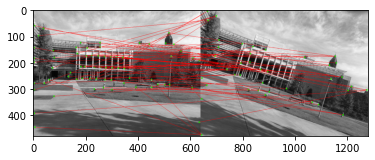

In [8]:
def ssd_correspondence(img_1, img_2, corners_xy_1, corners_xy_2, threshold=0, kernel_size=21):

    # Sum of squared difference

    # this is list of lists [[ind_1, ind_2, ssd_score], []]
    #  where ind_2 is index in 2nd img corner points matched with 1st corner point
    corr_1_to_2 = []

    win_pixels_2 = get_window(corners_xy_2, img_2, kernel_size)

    # Padding for corners
    pad = int(kernel_size/2)
    img_1 = np.pad(img_1, ((pad, pad), (pad, pad)), mode='edge')

    for i, corner_xy in enumerate(corners_xy_1 + pad):
        win_pixels_1 = img_1[corner_xy[1] - pad:corner_xy[1] + pad + 1, corner_xy[0] - pad:corner_xy[0] + pad + 1].flatten()

        ssd_score = np.sum((win_pixels_1 - win_pixels_2)**2, axis=1)
        ind_ssd = np.argmax(ssd_score)

        corr_1_to_2.append([i, ind_ssd, ssd_score[ind_ssd]])

    corr_1_to_2 = sorted(corr_1_to_2, key=lambda x: x[2])

    return corr_1_to_2


def ncc_correspondence(img_1, img_2, corners_xy_1, corners_xy_2, threshold, kernel_size=21):
    # Normalized cross correlation

    # this is list of lists [[ind_1, ind_2, ssd_score], []]
    #  where ind_2 is index in 2nd img corner points matched with 1st corner point
    corr_1_to_2 = []

    win_pixels_2 = get_window(corners_xy_2, img_2, kernel_size)
    win_pixels_2 = win_pixels_2 - np.mean(win_pixels_2, axis=1, keepdims=True)

    # Padding for corners
    pad = int(kernel_size / 2)
    img_1 = np.pad(img_1, ((pad, pad), (pad, pad)), mode='edge')

    for i, corner_xy in enumerate(corners_xy_1 + pad):
        win_pixels_1 = img_1[corner_xy[1] - pad:corner_xy[1] + pad + 1,
                       corner_xy[0] - pad:corner_xy[0] + pad + 1].flatten()

        win_pixels_1 = win_pixels_1 - np.mean(win_pixels_1)

        den = np.sqrt(np.sum(win_pixels_1**2) * np.sum(win_pixels_2**2, axis=1))

        ncc_score= np.sum((win_pixels_1 * win_pixels_2),axis=1)/ den

        ind_ssd = np.argmax(ncc_score)

        corr_1_to_2.append([i, ind_ssd, ncc_score[ind_ssd]])

    corr_1_to_2 = sorted(corr_1_to_2, key=lambda x: x[2], reverse=True)

    return corr_1_to_2


def euclidean_correspondence():
    # Minimum euclidean distance between feature descriptor vectors
    pass


def get_window(xy_crd, img_gray, kernel_size):

    win = int(kernel_size / 2)
    # Pad image to address corners near boundaries of image
    img_pad =  np.pad(img_gray, ((win, win), (win, win)), mode='edge')

    # the location of corners moves due to padding
    xy_crd = xy_crd + win
    ind = xy_crd[:, (1,0)] # converting to (r, c) notation

    def apply_func(ind_row, img, win):
        # print(ind_row)
        out = img[np.ix_(np.arange(ind_row[0]-win,ind_row[0]+win+1),
                              np.arange(ind_row[1]-win,ind_row[1]+win+1))].flatten()
        return out


    pix_win = np.apply_along_axis(apply_func, 1, ind, img_pad, win)

    return pix_win


def draw_correspondence(img_1, img_2, corr_1_to_2, pts_xy_1, pts_xy_2, dest_img_path='', max_lines=100):
    h, w, _ = img_1.shape
    # for i in range(pts_xy_1.shape[0]):
    #     cv2.circle(img_1, (pts_xy_1[i, 0], pts_xy_1[i, 1]), radius=3, color=[0, 255, 0], thickness=-1)
    #
    # for i in range(pts_xy_2.shape[0]):
    #     cv2.circle(img_2, (pts_xy_2[i, 0], pts_xy_2[i, 1]), radius=3, color=[0, 255, 0], thickness=-1)
    max_lines = pts_xy_1.shape[0]
    img_combined = np.hstack((img_1, img_2))
    print('max_lines', max_lines)
    for i in range(max_lines):
        x1, y1 = pts_xy_1[corr_1_to_2[i][0]]
        x2, y2 = pts_xy_2[corr_1_to_2[i][1]]
        x2 = x2 + w
        cv2.circle(img_combined, (x1, y1), radius=3, color=[0, 255, 0], thickness=-1)
        cv2.circle(img_combined, (x2, y2), radius=3, color=[0, 255, 0], thickness=-1)
        cv2.line(img_combined, (x1, y1), (x2, y2), (255, 0, 0), 1)
    plt.imshow(img_combined)
    if dest_img_path:
        cv2.imwrite(dest_img_path, img_combined)


def run_main(img_path, dest_img_path, nms_kernel_size, sigma=1.414, k=0.04, thresh=0.75, max_no_corners=-1, mode="ssd", corr_kernel_size=21):

    corners_xy_1 = detect_corners(img_path[0], dest_img_path='', nms_kernel_size=nms_kernel_size,
                                  sigma=sigma, k=k, thresh=thresh, max_no_corners=max_no_corners)

    corners_xy_2 = detect_corners(img_path[1], dest_img_path='', nms_kernel_size=nms_kernel_size,
                                  sigma=sigma, k=k, thresh=thresh, max_no_corners=max_no_corners)

    img_bgr_1 = load_image(img_path[0])
    img_1 = cv2.cvtColor(img_bgr_1, cv2.COLOR_BGR2GRAY)
    img_bgr_2 = load_image(img_path[1])
    img_2 = cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2GRAY)


    if mode == 'ssd':
        corr_1_to_2 = ssd_correspondence(img_1, img_2, corners_xy_1, corners_xy_2, threshold=0, kernel_size=corr_kernel_size)
    elif mode == 'ncc':
        corr_1_to_2 = ncc_correspondence(img_1, img_2, corners_xy_1, corners_xy_2, threshold=0, kernel_size=corr_kernel_size)

    draw_correspondence(img_bgr_1, img_bgr_2, corr_1_to_2, corners_xy_1, corners_xy_2, dest_img_path=dest_img_path)

if __name__ == "__main__":
    img_paths = [["/home/larissa-octos/Pictures/IT/simA.jpg",
                "/home/larissa-octos/Pictures/IT/simB.jpg"]]

    lst_sigma = [0.707, 1, 1.414, 2]
    nms_kernel_size = 25
    k = 0.04
    thresh = 0.75
    max_no_corners = 140
    corr_kernel_size = 21
    mode = ['ssd', 'ncc']

    results_dir = "/home/larissa-octos/Pictures"

    for img_path in img_paths:
        print(img_path)
        _, fname_1 = os.path.split(img_path[0])
        _, fname_2 = os.path.split(img_path[1])


        for sigma in lst_sigma:
            for m in mode:

                fname = "{}_{}_sig_{}_m_{}.jpg".format(fname_1.split('.')[0], fname_2.split('.')[0], sigma, m)

                print(" #### Processing {} ####".format(fname))

                dest_img_path = os.path.join(results_dir, fname)
                run_main(img_path, dest_img_path=dest_img_path, nms_kernel_size=nms_kernel_size,
                         sigma=sigma, k=k, thresh=thresh, max_no_corners=-1, mode=m, corr_kernel_size=corr_kernel_size)

['/home/larissa-octos/Pictures/IT/check.bmp', '/home/larissa-octos/Pictures/IT/check_rot.bmp']
 #### Processing check_check_rot_sig_0.707_m_ssd.jpg ####
max corner resp : 0.0961711073318216
min corner resp : -0.944735725308642
num corners before: 24
num corners after: 24
max corner resp : 0.17212764772718547
min corner resp : -0.9019412536196653
num corners before: 14
num corners after: 14
max_lines 24
 #### Processing check_check_rot_sig_0.707_m_ncc.jpg ####
max corner resp : 0.0961711073318216
min corner resp : -0.944735725308642
num corners before: 24
num corners after: 24
max corner resp : 0.17212764772718547
min corner resp : -0.9019412536196653
num corners before: 14
num corners after: 14
max_lines 24


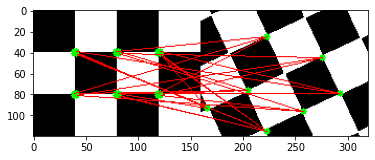

In [9]:
if __name__ == "__main__":
    img_paths = [["/home/larissa-octos/Pictures/IT/check.bmp",
                "/home/larissa-octos/Pictures/IT/check_rot.bmp"]]

    lst_sigma = [0.707]
    nms_kernel_size = 25
    k = 0.04
    thresh = 0.75
    max_no_corners = 500
    corr_kernel_size = 21
    mode = ['ssd', 'ncc']

    results_dir = "/home/larissa-octos/Pictures"

    for img_path in img_paths:
        print(img_path)
        _, fname_1 = os.path.split(img_path[0])
        _, fname_2 = os.path.split(img_path[1])


        for sigma in lst_sigma:
            for m in mode:

                fname = "{}_{}_sig_{}_m_{}.jpg".format(fname_1.split('.')[0], fname_2.split('.')[0], sigma, m)

                print(" #### Processing {} ####".format(fname))

                dest_img_path = os.path.join(results_dir, fname)
                run_main(img_path, dest_img_path=dest_img_path, nms_kernel_size=nms_kernel_size,
                         sigma=sigma, k=k, thresh=thresh, max_no_corners=-1, mode=m, corr_kernel_size=corr_kernel_size)

### 3. SIFT

Agora que você tem pontos-chave para os pares de imagens, podemos calcular descritores que proporcionarão desempenho mais robusto do que o casamento diretamente por meio dos valores dos pixels na Parte II. Você ficará feliz em saber que não esperamos que você escreva seu próprio código descritor SIFT. Em vez disso, você usará um as classes SIFT (ou SURF) no [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html). Para isso, será necessário que tenha instale o pacote `opencv-contrib-python` (basta executar a próxima célula caso já não esteja instalado).

O uso padrão de uma biblioteca SIFT consiste em você apenas fornecer uma imagem e a biblioteca faz seu trabalho: encontra pontos de interesse em várias escalas e calcula descritores em cada ponto. Também é possível fornecer os pontos de interesse já encontrados (como fizemos na Parte 1) para que se calculem seus descritores. No entanto, como vimos em aula, os cantos de Harris não são invariantes a escala enquanto os pontos característicos encontrados pelo SIFT o são. Portanto, vamos ignorar os pontos de interesse que você já detectou na Parte I.

In [10]:
!pip install opencv-contrib-python 

**A -** Obtenha os potnos característicos e mostre os pares de imagem lado a lado, representando cada ponto $(x,y)$ ecntrando, sua direção e escala (**dica:** use a função `cv2.drawKeypoints()` mais uma vez e preste atenção nos argumentos opcionais).

In [12]:
img1 = cv2.imread('images/simA.jpg')
#img1 = cv2.imread('images/check.bmp')
gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp1 = sift.detect(gray1,None)
img1=cv2.drawKeypoints(gray1,kp1,img1)
cv2.imwrite('sift_keypoints.jpg',img1)

True

Agora com os descritores, precisamos combiná-los. Isso é o que chamamos de correspondências putativas na aula.

Na Parte II, obtivemos as melhores correspondências manualmente a partir da razão entre o menor SSD e o segundo menor. Dessa vez, vamos usar a classe [`BFMatcher`](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html) do OpenCV.

**B -** Encontre as correspondências putativas e as exiba junto às imagens usando `cv2.drawMatches()`.

In [13]:
img1=cv2.drawKeypoints(gray1,kp1,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints.jpg',img1)

True

In [16]:
#Encontre os pontos-chave e descritores com SIFT
kp1, des1 = sift.detectAndCompute(gray1,None)

In [17]:
kp1

[<KeyPoint 0x7f795c219090>,
 <KeyPoint 0x7f795c1ee990>,
 <KeyPoint 0x7f7929c37780>,
 <KeyPoint 0x7f792033f1b0>,
 <KeyPoint 0x7f792033fa20>,
 <KeyPoint 0x7f792033fa80>,
 <KeyPoint 0x7f792033fb70>,
 <KeyPoint 0x7f792033fb40>,
 <KeyPoint 0x7f792033f090>,
 <KeyPoint 0x7f792033fba0>,
 <KeyPoint 0x7f792033fb10>,
 <KeyPoint 0x7f792033f540>,
 <KeyPoint 0x7f792033f240>,
 <KeyPoint 0x7f792033f2a0>,
 <KeyPoint 0x7f792033f180>,
 <KeyPoint 0x7f792033fd50>,
 <KeyPoint 0x7f792033f210>,
 <KeyPoint 0x7f792033f060>,
 <KeyPoint 0x7f792033f300>,
 <KeyPoint 0x7f79200af600>,
 <KeyPoint 0x7f79200af570>,
 <KeyPoint 0x7f79200af5a0>,
 <KeyPoint 0x7f79200af750>,
 <KeyPoint 0x7f79200af5d0>,
 <KeyPoint 0x7f79200af540>,
 <KeyPoint 0x7f79200af840>,
 <KeyPoint 0x7f79200af8d0>,
 <KeyPoint 0x7f79200af8a0>,
 <KeyPoint 0x7f79200af9c0>,
 <KeyPoint 0x7f79200af990>,
 <KeyPoint 0x7f79200af6f0>,
 <KeyPoint 0x7f79200afa20>,
 <KeyPoint 0x7f79200af480>,
 <KeyPoint 0x7f79200af720>,
 <KeyPoint 0x7f79200afa50>,
 <KeyPoint 0x7f79200

In [18]:
des1

array([[ 41.,  26.,  11., ...,   3.,   0.,   1.],
       [  0.,   0.,   0., ...,   0.,   0.,   7.],
       [  0.,   0.,   0., ...,  12.,   0.,   1.],
       ...,
       [  0.,   1.,  51., ...,   0.,   0.,   1.],
       [ 25., 127.,  42., ...,  16.,   3.,   1.],
       [  1.,   3.,   6., ...,   0.,   0.,   0.]], dtype=float32)

In [19]:
img2 = cv2.imread('images/simB.jpg')
#img2 = cv2.imread('images/check_rot.bmp')
gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp2 = sift.detect(gray2,None)
img2=cv2.drawKeypoints(gray2,kp2,img2)
cv2.imwrite('sift_keypoints2.jpg',img2)

True

In [20]:
img2=cv2.drawKeypoints(gray2,kp2,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints2.jpg',img2)

True

In [25]:
#Função para generalizar os descritores 
#Ela é usada na questão sobre RANSAC
def detectAndDescribe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Imagem para a Escala de cinza
    #Detectar e extrair features da imagem
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    # Converter os key points para np.array
    kps = np.float32([kp.pt for kp in kps])
    # Retornar uma tupla de key points e features
    return (kps, features)

### 4. RANSAC

Estamos quase lá. Agora você tem pontos-chave, descritores e suas correspondências putativas. O que resta é o RANSAC.

Lembre-se de que uma transformação de similaridade permite translação, rotação e escala. Podemos representar essa transformação que leva um ponto $(u,v)$ para $(u',v')$ por uma matriz como:
\begin{equation}
      \begin{pmatrix}
          a & -b & c \\
          b & a  & d
      \end{pmatrix}
      \begin{pmatrix}
          u \\
          v \\
          1
      \end{pmatrix}
      =
      \begin{pmatrix}
          u' \\
          v'
      \end{pmatrix}
      \mathrm{,}
\end{equation}
onde $a$, $b$, $c$ e $d$ são as quatro incógnitas.

Cada correspondência fornece duas equações - então você precisa escolher duas correspondências para resolver, razão pela qual a similaridade é chamada de transformação de dois pontos.

#### Pseudo-código

 1. Inicialize o número $N$ de interações do algoritmo (tipicamente, $200<N<500$);
 2. Usando os pontos-chave da imagem, selecione aleatoriamente duas correspondências putativas;
 3. Calule a transformação entre as duas imagens com base nas correspondências selecionadas (você lembra como se resolve o sistema de equações $Ax = b$?);
 4. Descubra a qualidade dessa transformação (ou seja, quantas outras correspondências putativas concordam, dentro de uma tolerância, com essa transformação):
   1. Calcule o erro dado pela distância euclidiana $E_k = D((x'_k, y'_k, 1)^t, A(x_k, y_k, 1)^t)$ para cada correspondência $k$ na imagem original e a imagem transformada;
   2. Determine um critério para decidir se cada correspondência $k$ é considerada como *inlier* para a transformação $A$ calculada na iteração;
 5. Escolha a melhor transformação - aquela com o maior número número de *inliers* (maior conjunto de consenso).

**A -** Descubra qual a transformação de similaridade que leva uma imagem na outra e superponha a imagem alvo com a imagem transformada (**dica:** [`cv2.addWeighted()`](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#image-blending).

In [26]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB,
    ratio, reprojThresh):
    # Computar as correspondências brutas 
    # Inicializar a lista de correspondências reais
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []

    # Fazer um loop com as correspondências brutas
    for m in rawMatches:
        # Certifique-se de que a distância está dentro de uma certa proporção, uma da outra.
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # Computar uma homografia requer pelo menos 4 partidas
    if len(matches) > 4:
        # Construir os dois conjuntos de pontos
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])

        # Computar a homografia entre os dois conjuntos de pontos
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)

        # Retornar as correspondências junto com a matriz de homografia e o status de cada ponto correspondido
        return (matches, H, status)
    
    # Caso contrário, nenhuma homografia poderia ser calculada
    return None

def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # Inicializar a imagem de visualização de saída
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # Fazer um loop sobre as correspondências
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # Só processe a correspondência se o ponto-chave for correspondido com sucesso
        if s == 1:
            # Desenhando as correspondências
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # Retornar a visualização
    return vis

In [31]:
imgLeft = cv2.imread("images/simA.jpg")
imgRight = cv2.imread("images/simB.jpg")

kpl,descl = detectAndDescribe(imgLeft)
kpr,descr = detectAndDescribe(imgRight)
## H é a homografia
m,H,status = matchKeypoints(kpl,kpr,descl,descr,ratio=0.75, reprojThresh=4.0)
b = drawMatches(imgLeft,imgRight,kpl,kpr,m,status)

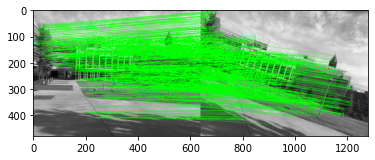

(<matplotlib.image.AxesImage at 0x7f790280fb80>, None)

In [37]:
plt.imshow(b, 'gray'),plt.show()

In [34]:
H

array([[ 1.00667582e+00, -2.98881253e-01,  3.68430720e+01],
       [ 3.07118516e-01,  9.68472353e-01, -6.26157939e+01],
       [ 8.65949183e-05, -8.19365615e-05,  1.00000000e+00]])

In [35]:
status

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
    

**B -** -Qual porcentagem dos casamentos estava alinhada com a melhor transformação? A transformação encontrada é razoável?

In [ ]:
## INSIRA AQUI O CÓDIGO